# Annual Cycle Climatology Test: CDAT vs Xarray

[Jiwoo Lee](https://github.com/lee1043/) (LLNL), March 2021

In this document, annual cycle climatology fields calculated using [CDAT](https://cdat.llnl.gov/) and [Xarray](xarray.pydata.org/) are compared for checking consistency.

NOTE: CDAT's annual cycle climatology obtained from `cdutil.ANNUALCYCLE.climatology` seems to be not weighted with leap year associated weighting.

Useful resources:
- [Xarray instrcution from NCI data training](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_01_Xarray_access_CMIP5.html)
- [Xarray example: Calculating Seasonal Averages from Time Series of Monthly Means](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

## Example input data

In [1]:
input_file = "demo_data/CMIP5_demo_data/ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc"
#input_file = "demo_data/CMIP5_demo_data/ts_Amon_dummy_185001-185412.nc"

## Import libraries

In [2]:
import cdms2
import cdutil

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## CDAT

### Load data

In [5]:
%%time

fc = cdms2.open(input_file)
dc = fc('ts', time=slice(0,48)) #- 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 24.2 ms, sys: 46 ms, total: 70.2 ms
Wall time: 247 ms


### Calculate Seasonal Climatology

In [6]:
%%time

dc_ann_clim = cdutil.ANNUALCYCLE.climatology(dc)

CPU times: user 193 ms, sys: 9.44 ms, total: 202 ms
Wall time: 201 ms


In [7]:
print(dc_ann_clim.shape)

dc_ann_clim.id = dc.id
dc_ann_clim.getTime().asComponentTime()

(12, 145, 192)


[1-1-16 12:0:0.0,
 1-2-15 0:0:0.0,
 1-3-16 12:0:0.0,
 1-4-16 0:0:0.0,
 1-5-16 12:0:0.0,
 1-6-16 0:0:0.0,
 1-7-16 12:0:0.0,
 1-8-16 12:0:0.0,
 1-9-16 0:0:0.0,
 1-10-16 12:0:0.0,
 1-11-16 0:0:0.0,
 1-12-16 12:0:0.0]

In [8]:
dc_ann_clim

ts
masked_array(
  data=[[[252.80220413208008, 252.80220413208008, 252.80220413208008,
          ..., 252.80220413208008, 252.80220413208008,
          252.80220413208008],
         [254.00109100341797, 253.9766960144043, 253.9508171081543, ...,
          254.05484771728516, 254.0404510498047, 254.02033233642578],
         [254.9943084716797, 254.91951751708984, 254.84015274047852,
          ..., 255.21722412109375, 255.13978576660156,
          255.0703239440918],
         ...,
         [236.2349624633789, 236.31228256225586, 236.39718627929688,
          ..., 236.02045822143555, 236.0816535949707,
          236.15680694580078],
         [235.76531219482422, 235.80900192260742, 235.85339736938477,
          ..., 235.63568496704102, 235.68157958984375,
          235.72282028198242],
         [235.50418853759766, 235.50418853759766, 235.50418853759766,
          ..., 235.50418853759766, 235.50418853759766,
          235.50418853759766]],

        [[237.36708068847656, 237.36708068847656

### Global area average

In [9]:
%%time

dc_ann_clim_ts = cdutil.averager(dc_ann_clim, axis='xy')
dc_ann_clim_ts.id = dc.id

CPU times: user 19.1 ms, sys: 6.15 ms, total: 25.2 ms
Wall time: 23.7 ms


### Convert data type for quick plotting

Convert array type from CDAT transient variable to Xarray data array

In [10]:
time = dc.getTime()
lat = dc.getLatitude()
lon = dc.getLongitude()

In [11]:
dc_ann_clim_xr = xr.DataArray(dc_ann_clim, 
                              coords=[list(time)[0:12], list(lat), list(lon)], 
                              dims=["time", "lat", "lon"], 
                              name=dc.id)

## Xarray

### Load data

In [12]:
%%time
fx = xr.open_dataset(input_file, decode_times=True)
dx = fx.ts[0:48] #- 273.15  # Take first 4 years (0-48) and unit adjust (-273.15, K to C)

CPU times: user 278 ms, sys: 11.1 ms, total: 290 ms
Wall time: 298 ms


### Calculating Seasonal Averages from Timeseries of Monthly Means

Adapted from example at http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [13]:
def annual_cycle_climatology(d, weighted=True):
    if weighted:
        # Make a DataArray with the number of days in each month, size = len(time)
        month_length = d.time.dt.days_in_month

        # Calculate the weights by grouping by 'time.month'
        weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

        # Calculate the weighted average
        return (d * weights).groupby('time.month').sum(dim='time')
    else:
        # Alternative way (https://github.com/willyhagi/climate-data-science/blob/master/Python-Scripts/annual_cycle.py)
        # Does not consider weighting
        return d.groupby('time.month').mean('time')

In [14]:
def annual_cycle_climatology_manual_test(dx):
    d1 = dx[1].time.dt.days_in_month
    d2 = dx[13].time.dt.days_in_month
    d3 = dx[25].time.dt.days_in_month
    d4 = dx[37].time.dt.days_in_month

    w1 = d1 / (d1+d2+d3+d4)
    w2 = d2 / (d1+d2+d3+d4)
    w3 = d3 / (d1+d2+d3+d4)
    w4 = d4 / (d1+d2+d3+d4)

    return (dx[1]*w1 + dx[13]*w2 + dx[25]*w3 + dx[37]*w4)

In [15]:
%%time

# With weighting
dx_ann_clim = annual_cycle_climatology(dx)

CPU times: user 44.2 ms, sys: 15.9 ms, total: 60.1 ms
Wall time: 65.3 ms


In [16]:
%%time

# Without weighting
dx_ann_clim_no_weight = annual_cycle_climatology(dx, weighted=False)

CPU times: user 126 ms, sys: 6.17 ms, total: 132 ms
Wall time: 132 ms


In [17]:
%%time

# With weighting -- manual
dx_ann_clim_manual_weight = annual_cycle_climatology_manual_test(dx)

CPU times: user 15.3 ms, sys: 4.19 ms, total: 19.5 ms
Wall time: 18.4 ms


In [18]:
dx_ann_clim

<xarray.DataArray (month: 12, lat: 145, lon: 192)>
array([[[252.80220413, 252.80220413, 252.80220413, ..., 252.80220413,
         252.80220413, 252.80220413],
        [254.001091  , 253.97669601, 253.95081711, ..., 254.05484772,
         254.04045105, 254.02033234],
        [254.99430847, 254.91951752, 254.84015274, ..., 255.21722412,
         255.13978577, 255.07032394],
        ...,
        [236.23496246, 236.31228256, 236.39718628, ..., 236.02045822,
         236.08165359, 236.15680695],
        [235.76531219, 235.80900192, 235.85339737, ..., 235.63568497,
         235.68157959, 235.72282028],
        [235.50418854, 235.50418854, 235.50418854, ..., 235.50418854,
         235.50418854, 235.50418854]],

       [[237.38017165, 237.38017165, 237.38017165, ..., 237.38017165,
         237.38017165, 237.38017165],
        [239.75111484, 239.70014954, 239.64622795, ..., 239.91645421,
         239.86269075, 239.80553105],
        [240.7344251 , 240.57791124, 240.4187884 , ..., 241.16554098,
         241.04377477, 240.89214264],
...
        [244.95588303, 244.97372818, 244.98755646, ..., 244.90076828,
         244.930336  , 244.93497086],
        [244.52415848, 244.53188324, 244.54083252, ..., 244.51695251,
         244.51230621, 244.51852036],
        [243.80155182, 243.80155182, 243.80155182, ..., 243.80155182,
         243.80155182, 243.80155182]],

       [[253.01467514, 253.01467514, 253.01467514, ..., 253.01467514,
         253.01467514, 253.01467514],
        [253.89181519, 253.87600708, 253.86038208, ..., 253.90908432,
         253.90317917, 253.89376068],
        [254.73023224, 254.66717529, 254.62160492, ..., 254.89841843,
         254.84388351, 254.78485107],
        ...,
        [239.79124451, 239.81863785, 239.83936691, ..., 239.70016861,
         239.73005676, 239.75947571],
        [239.0462532 , 239.04780197, 239.0575943 , ..., 239.01149368,
         239.02973175, 239.04354477],
        [237.73281097, 237.73281097, 237.73281097, ..., 237.73281097,
         237.73281097, 237.73281097]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Global area average

Reference: http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

In [19]:
def area_averager(d):
    weights = np.cos(np.deg2rad(d.lat))
    weights.name = "weights"
    d_weighted = d.weighted(weights)
    d_weighted_mean = d_weighted.mean(("lon", "lat"))
    return(d_weighted_mean)

In [20]:
%%time

dx_ann_clim_ts = area_averager(dx_ann_clim)
dx_ann_clim_ts_no_weight = area_averager(dx_ann_clim_no_weight)

CPU times: user 16.3 ms, sys: 2.28 ms, total: 18.6 ms
Wall time: 17.8 ms


### Quick plot to show the results

## Check Difference between CDAT and Xarray

### Map

Text(0.5, 1.02, 'Surface Air Temperature at t=1, first Feb.')

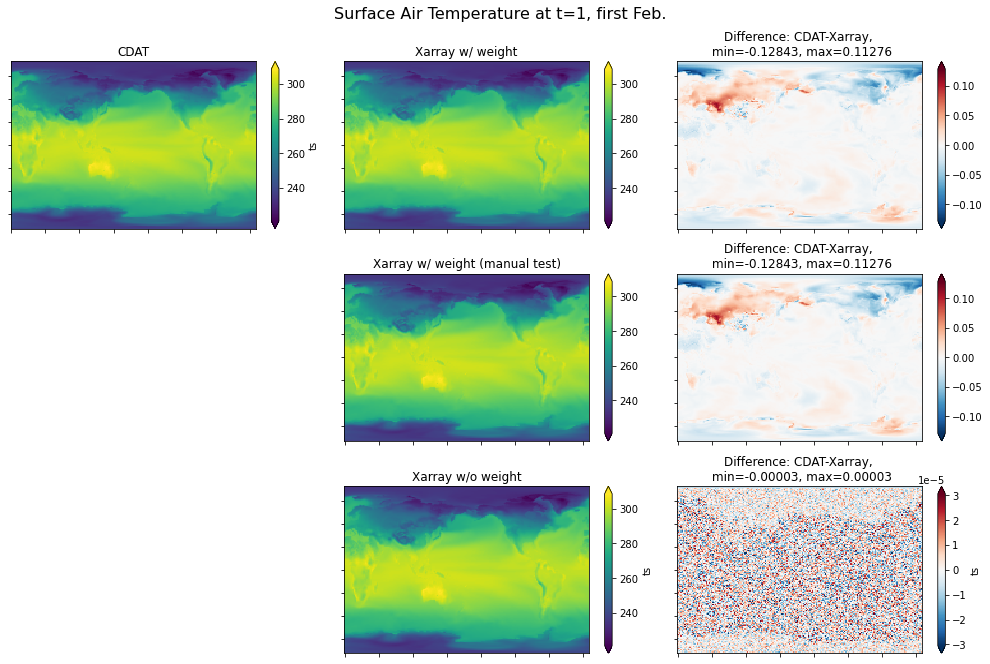

In [21]:
tstep = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,9))

notnull = pd.notnull(dx_ann_clim[tstep])

for i in range(3):
       
    cmap = 'Spectral_r'
    vmin = -30
    vmax = 30

    cmap_diff = 'RdBu_r'
    vmin_diff = -0.1
    vmax_diff = 0.1
        
    # CDAT
    if i == 0:
        dc_ann_clim_xr[tstep].plot.pcolormesh(
            ax=axes[i, 0], 
            #vmin=vmin, vmax=vmax, cmap=cmap,
            add_colorbar=True, extend='both') 
    else:
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        axes[i,0].spines['bottom'].set_color('white')
        axes[i,0].spines['top'].set_color('white')
        axes[i,0].spines['left'].set_color('white')
        axes[i,0].spines['right'].set_color('white')
    
    if i == 0:
        dx_tmp = dx_ann_clim[tstep]
    elif i == 1:
        dx_tmp = dx_ann_clim_manual_weight
    elif i == 2:
        dx_tmp = dx_ann_clim_no_weight[tstep]
    
    # Xarray
    dx_tmp.plot.pcolormesh(
        ax=axes[i, 1], 
        #vmin=vmin, vmax=vmax, cmap=cmap,
        add_colorbar=True, extend='both')

    # CDAT - Xarray
    diff = dc_ann_clim_xr[tstep] - dx_tmp
    diff.plot.pcolormesh(
        ax=axes[i, 2], 
        #vmin=vmin_diff, vmax=vmax_diff, cmap=cmap_diff,
        add_colorbar=True, extend='both')
    axes[i,2].set_title('Difference: CDAT-Xarray, \n min='+str("{:.5f}".format(diff.values.min()))+', max='+str("{:.5f}".format(diff.values.max())))
        
        
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_title('')

axes[0, 0].set_title('CDAT')
axes[0, 1].set_title('Xarray w/ weight')
axes[1, 1].set_title('Xarray w/ weight (manual test)')
axes[2, 1].set_title('Xarray w/o weight')
#axes[0, 2].set_title('Difference: CDAT-Xarray')

plt.tight_layout()

fig.suptitle('Surface Air Temperature at t='+str(tstep)+', first Feb.', fontsize=16, y=1.02)

In [22]:
diff.values.min()

-3.0517578125e-05

### Time Series

Text(0.5, 1.02, 'Surface Air Temperature Annual Cycle Climatology')

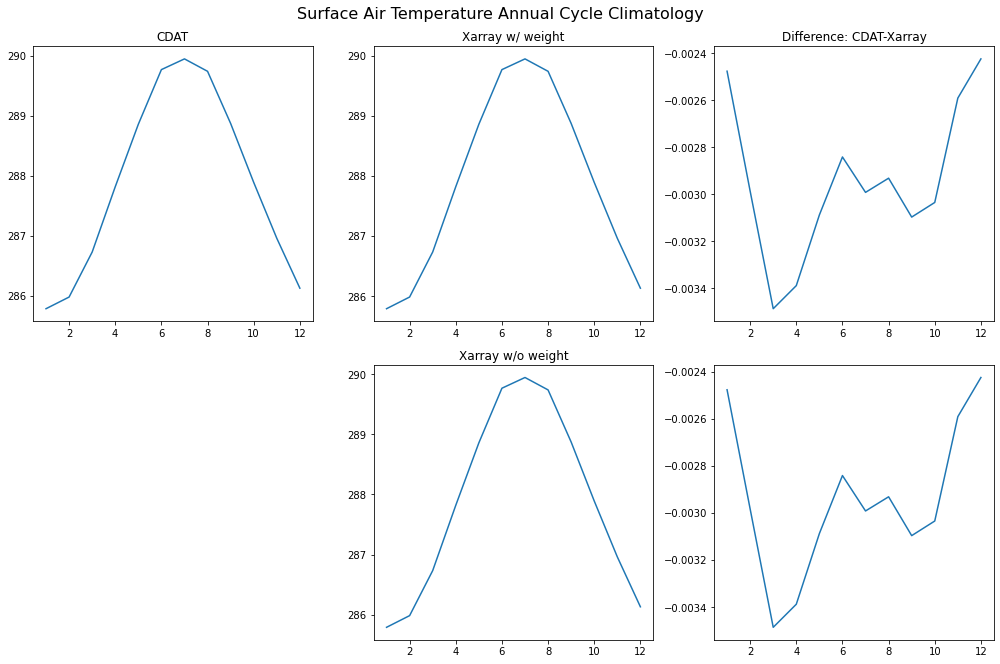

In [23]:
tstep = 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,9))

x = list(range(1,13))

for i in range(2):
       
    cmap = 'Spectral_r'
    vmin = -30
    vmax = 30

    cmap_diff = 'RdBu_r'
    vmin_diff = -0.1
    vmax_diff = 0.1
        
    # CDAT
    if i == 0:
        y = dc_ann_clim_ts.tolist()
        axes[i,0].plot(x, y)
    else:
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        axes[i,0].spines['bottom'].set_color('white')
        axes[i,0].spines['top'].set_color('white')
        axes[i,0].spines['left'].set_color('white')
        axes[i,0].spines['right'].set_color('white')
    
    # Xarray
    if i == 0:
        dx_tmp = dx_ann_clim_ts.values.tolist()
    elif i == 1:
        dx_tmp = dx_ann_clim_ts_no_weight.values.tolist()
    
    axes[i,1].plot(x, dx_tmp)

    # CDAT - Xarray
    y = list(dc_ann_clim_ts - dx_tmp)
    axes[i,2].plot(x, y)
    
        
for ax in axes.flat:
    ax.axes.axis('tight')
    ax.set_title('')

axes[0, 0].set_title('CDAT')
axes[0, 1].set_title('Xarray w/ weight')
axes[1, 1].set_title('Xarray w/o weight')
axes[0, 2].set_title('Difference: CDAT-Xarray')

plt.tight_layout()

fig.suptitle('Surface Air Temperature Annual Cycle Climatology', fontsize=16, y=1.02)

Difference in time series may come from difference of area average weighting.